# Оценка матрицы переходных вероятностей

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [29]:
with open('data/materials/alice_en.txt', 'r') as f:
    text = f.read().lower()
text = re.sub('[^a-z]', '', text)

In [30]:
# with open('data/materials/alice_ru.txt', 'r', encoding='koi8-r') as f:
#     text = f.read().lower()
# text = re.sub('[^а-я]', '', text)

In [31]:
text[:20]

'projectgutenbergsali'

In [32]:
ENGLISH = 'abcdefghijklmnopqrstuvwxyz'
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя'
POS = {l: i for i, l in enumerate(ENGLISH)}
#POS = {l: i for i, l in enumerate(RUSSIAN)}

In [33]:
probabilities = np.zeros((len(ENGLISH), len(ENGLISH)))
#probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [34]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [35]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [36]:
df = pd.DataFrame(probabilities, index=(c for c in ENGLISH), columns=(c for c in ENGLISH))
#df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

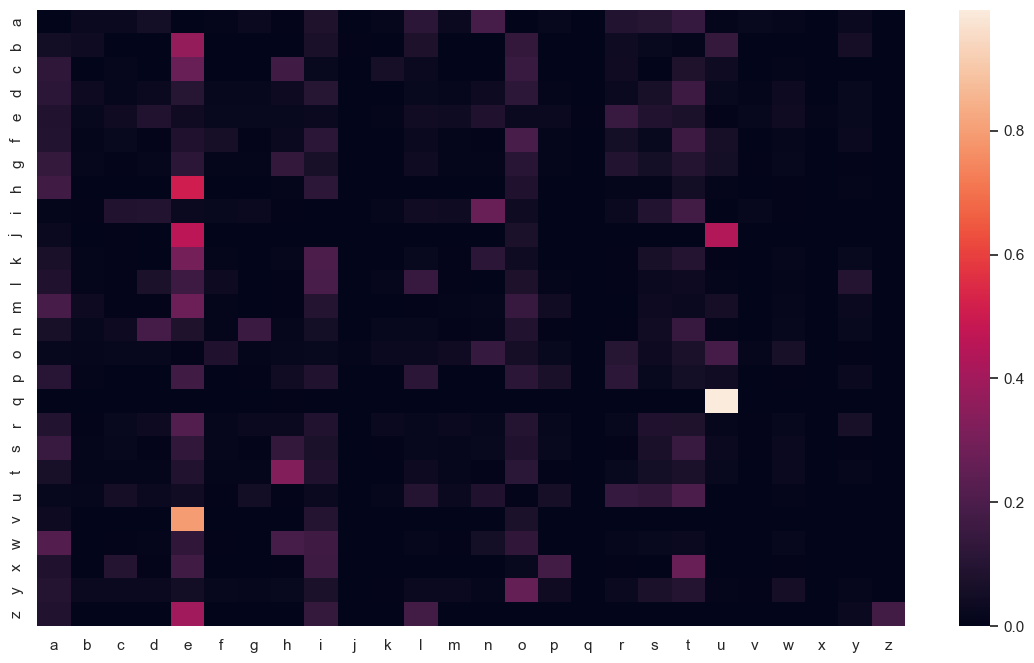

In [37]:
plt.figure(figsize=(14, 8))
sns.heatmap(df)
plt.show()

# Траектория в цепи

Теперь вопрос: допустим, что у нас есть какая-то траектория (последовательность состояний). Какова её вероятность? Ответ на этот вопрос даст одна простая теорема.

**Теорема о состояниях марковской цепи**

Для любого натурального $n$ и любых $i_0,i_1,…,i_{n−1},i,j$

$P(X_0=i_0,X_1=i_1,…,X_n=i_n)=α_{i_0}p_{i_0i_1}…p{i_{n−1}i_n}.$

Пример: Пусть вероятность начального состояния цепи для букв английского алфавита равна $\dfrac{1}{26}$.
Чему равна вероятность наблюдать строку "hello"?

In [11]:
string = "hello"
proba = 1.0 / 26
for cp, cn in zip(string[1:], string[:-1]):
    proba *= probabilities[POS[cp], POS[cn]]
print(proba)

5.348363016330027e-07


**Следствие.** Для любого натурального $n$ и любого $i_n \in E$

$P(X_n=i_n) = \sum \limits_{i_0,…,i_{n−1} \in E} \alpha i_0p_{i_0i_1}…p_{i_{n−1}i_n}$.

Но обычно нас не интересует полный путь, а лишь начало и конец. Поэтому вводят вероятность перейти из состояния $i$ в состояние $j$ за $n$ шагов:

$p_{ij}^{(n)}=P(X_n=j|X_0=i)$

Чему равна эта вероятность?

$P(X_n=j|X_0=i)=\dfrac{P(X_n=j,X_0=i)}{P(X_0=i)}=\sum \limits_{i_0,…,i_{n−1} \in E} \dfrac{P(X_0=i, X_1=i_1,...,X_{n-1}=i_{n-1}, X_n = j)}{P(X_0=i)}=\sum \limits_{i_0,…,i_{n−1} \in E} p_{ii_1}...p_{i_{n-1}j}$

Если мы посмотрим на случай $n=2$, то полученное выражение очень похоже на скалярное произведение строк матрицы переходной вероятности. Оказывается, что это не так уж и далеко от истины.

In [38]:
start = POS['h']
end = POS['y']
prior = 1. / len(ENGLISH)
for c in ENGLISH:
    proba = prior * probabilities[start, POS[c]] * probabilities[POS[c], end]
    if proba > 0:
        print(''.join(['h', c, 'y']), proba)

hay 0.00019786241179454468
hby 3.2498131357446945e-06
hcy 2.5963886570530186e-07
hdy 2.00246712505073e-06
hey 0.00041670464060019366
hfy 2.4496387427496224e-06
hgy 2.2022341052346015e-07
hhy 3.0694052582470812e-06
hky 1.0202901705244971e-07
hly 6.987940162352581e-06
hmy 4.054691865351508e-06
hny 1.0187698076726042e-06
hoy 2.0758961455728112e-05
hpy 2.095534994542692e-06
hry 2.9097918521227684e-05
hsy 2.6301624264116166e-06
hty 2.5534949950507335e-05
huy 2.316043298098595e-07
hvy 3.0372085380791536e-08
hwy 6.902550257831721e-07
hyy 4.816238159185105e-06


# Генерирование выборок из марковской цепи

Как создать реализацию длины $N$ из марковской цепи?
Сгенерировать начальное состояние согласно распределению $\alpha_i≡P(X_0=i)$, положить $n \leftarrow 0$.
Пока $n<N$, повторять:
- Имея контекст $X_n$, сгенерировать состояние $X_{n+1}$ из распределения $P(X_{n+1}|X_n)$
- Положить $n \leftarrow n+1$

In [39]:
s = []
start = np.random.choice(list(ENGLISH))
s.append(start)
lenght = 10
for i in range(lenght):
    index = POS[s[i]]
    next_char = np.random.choice(list(ENGLISH), p=probabilities[index])
    s.append(next_char)
print(''.join(s))

lindtdtheot


# Модели временных рядов с переключениями

Обозначим $s_t$ ненаблюдаемую переменную состояния, принимающую значения 0 или 1. Простейшая модель переключения для переменной $z_t$ состоит из двух спецификаций типа AR:

$z_t = \begin{cases} \alpha_0 + \beta z_{t-1} + \epsilon_t, & s_t = 0 \\ \alpha_0 + \alpha_1 + \beta z_{t-1} + \epsilon_t, & s_t = 1 \end{cases}$
 
где $|\beta|<1$ и $\epsilon_t i.i.d.$ с нулевым средним и дисперсией $\sigma^2_\epsilon$.

In [40]:
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1
beta = .05
s = np.random.binomial(n=1, p=.8, size=100)
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps

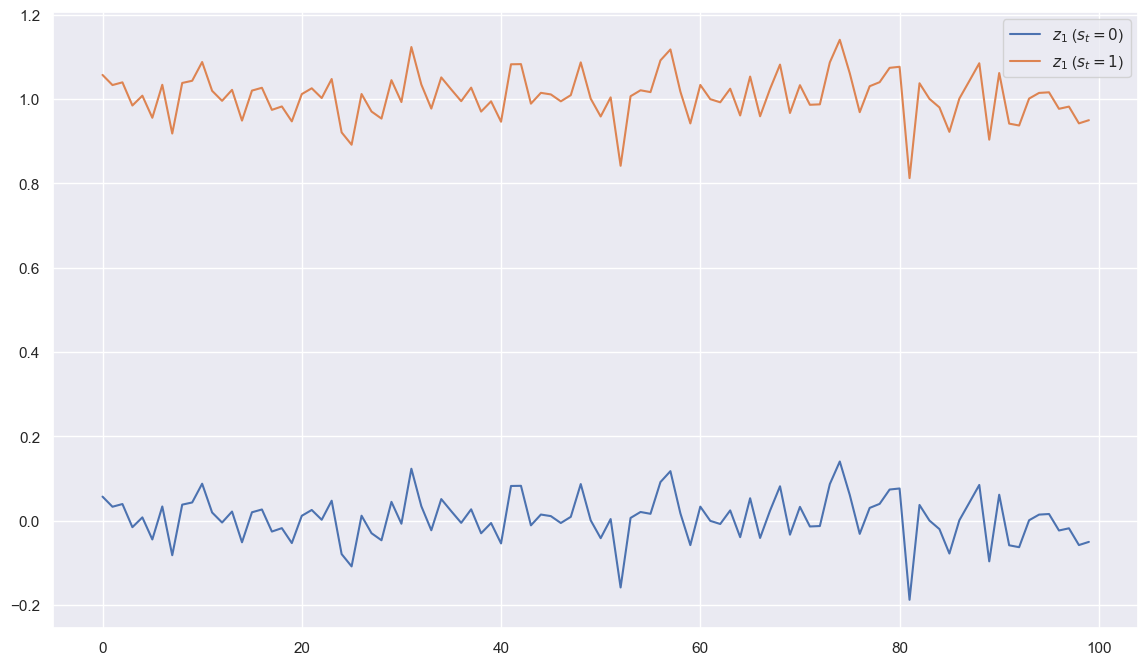

In [41]:
plt.figure(figsize=(14,8))
plt.plot(z1, label='$z_1$ ($s_t = 0$)')
plt.plot(z2, label='$z_1$ ($s_t = 1$)')
plt.legend()
plt.show()

In [43]:
z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

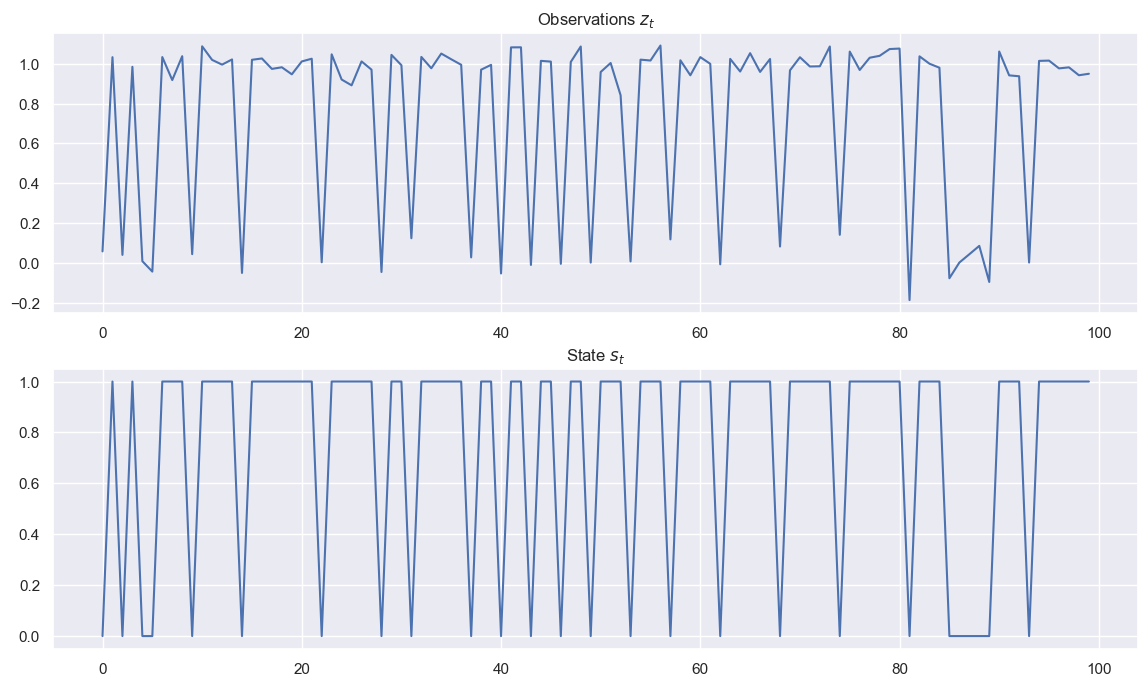

In [44]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

# Как сгенерировать траекторию модели с марковскими переключениями?

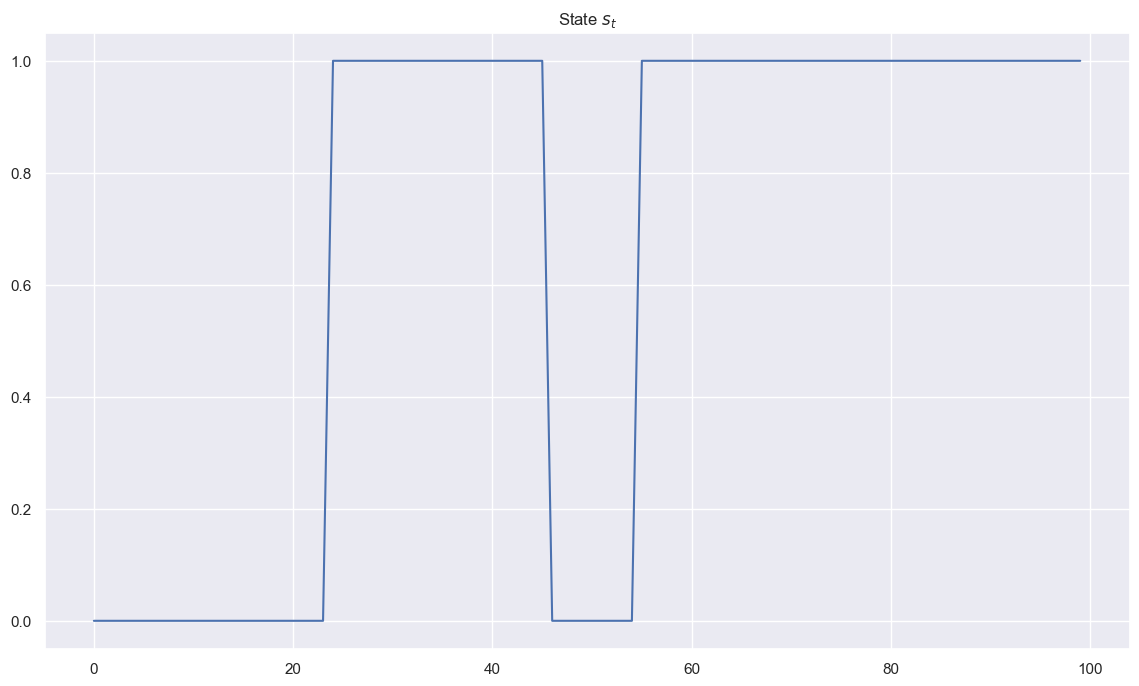

In [47]:
# 1. Генерирование марковской цепи с 2 скрытыми состояниями
P = np.array([
    [.95, .05],
    [.05, .95]
])
s = [0]
for t in range(99):
    distribution = P[s[-1]]
    s.append(np.random.choice([0, 1], p=distribution))
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
axs.plot(s)
axs.set_title('State $s_t$')
plt.show()

In [51]:
#2. Генерирование наблюдений из распределений, обусловленных ненаблюдаемым состоянием
eps = np.random.normal(size=100)
alpha_0 = 0.
alpha_1 = 1.
beta = .05
z1 = alpha_0 + beta * eps
z2 = alpha_0 + alpha_1 + beta * eps
z = []
for t, s_t in enumerate(s):
    if s_t == 0:
        z.append(z1[t])
    else:
        z.append(z2[t])

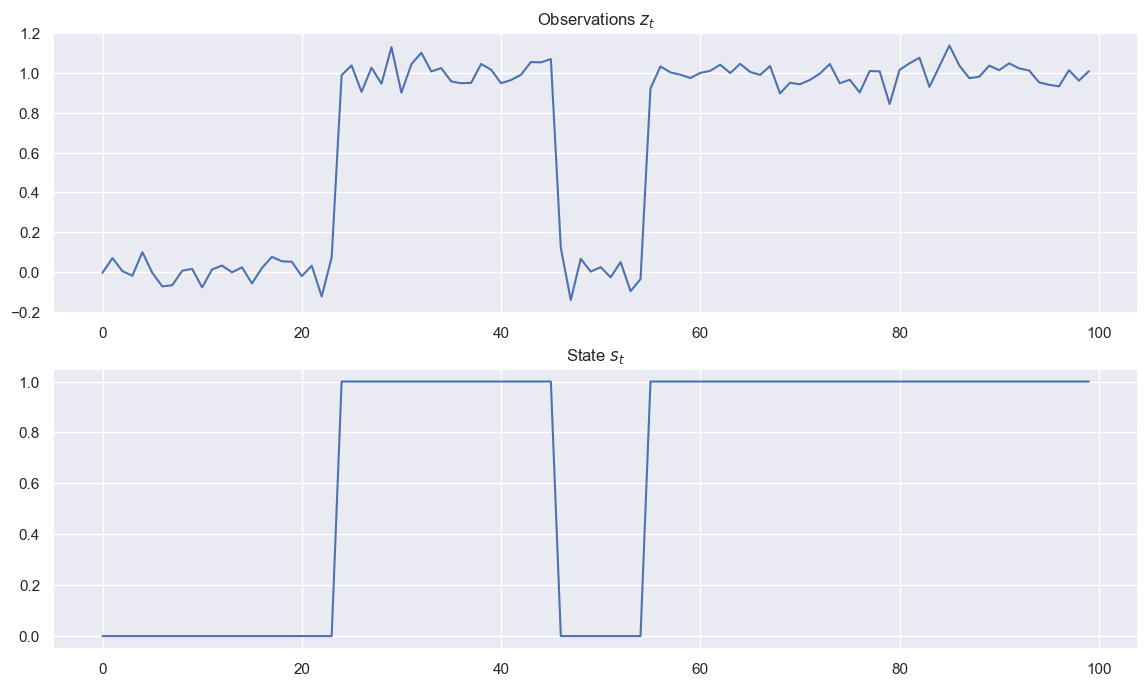

In [52]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axs[0].plot(z)
axs[0].set_title('Observations $z_t$')
axs[1].plot(s)
axs[1].set_title('State $s_t$')
plt.show()

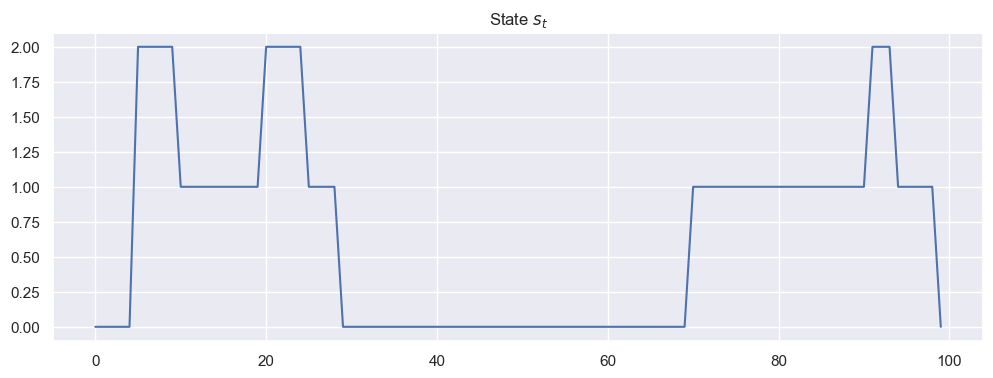

In [53]:
P = np.array([
    [0.95, 0.025, 0.025],
    [0.025, 0.95, 0.025],
    [0.025, 0.025, 0.95],
])

s = [0]
for t in range(99):
    distribution = P[s[-1]]
    s.append(np.random.choice([0, 1, 2], p=distribution))

f, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
_ = axs.plot(s)
_ = axs.set_title('State $s_t$')
plt.show()

In [54]:
np.array(s)

array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0])

# Индикаторные функции

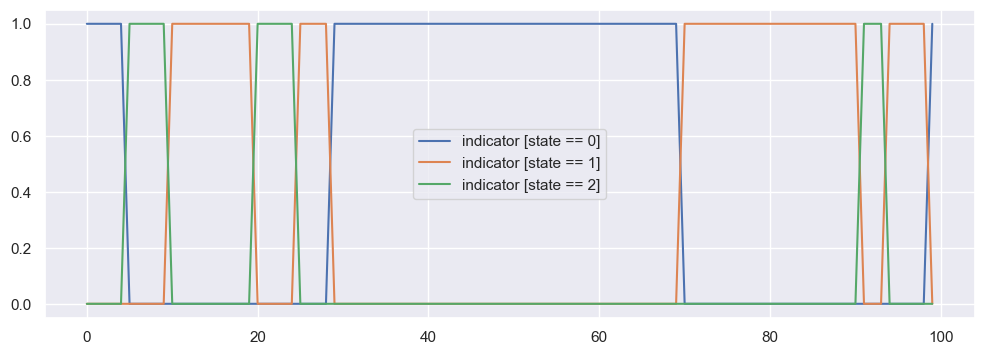

In [55]:
t = np.zeros((3, 100))
for i in range(3):
    t[i, :] = (np.array(s) == i).astype(int)
    
f, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
for i in range(3):
    _ = axs.plot(t[i, :], label='indicator [state == {}]'.format(i))
_ = axs.legend()

In [56]:
a, b = np.where(t)
assert np.all(np.array(a[np.argsort(b)]) == np.array(s))